In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import itertools
from collections import Counter
import pandas as pd
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
import random
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
random.seed(42)

In [66]:
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/plant_genes_GSE181536_TPM_data/plant_genes_GSE181536_TPM_data_Root TRAP_mgd.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/plant_genes_GSE181536_TPM_data/plant_genes_GSE181536_TPM_data_shoot_trap.csv")
final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/plant_genes_GSE181536_TPM_data/plant_genes_GSE181536_TPM_data_shoot_trap_mgd.csv")

#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF910TAZ/hg38_msxTm_ENCFF910TAZ.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF292FVY/hg38_msxTm_ENCFF292FVY.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF597FGD/hg38_msxTm_ENCFF597FGD.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF279XTY/hg38_msxTm_ENCFF279XTY.csv")

In [26]:
def all_kmers(kmer_size):
    bases=['A','T','G','C']
    return [''.join(p) for p in itertools.product(bases, repeat=kmer_size)]

In [27]:
def count_occurance(seq_kmer_list):
    return [[x,seq_kmer_list.count(x)] for x in set(seq_kmer_list)]

In [28]:
def seq2kmer(seq, k):
    """
    Convert original sequence to kmers
    
    Arguments:
    seq -- str, original sequence.
    k -- int, kmer of length k specified.
    
    Returns:
    kmers -- str, kmers separated by space
    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    return kmer

In [29]:
def add_kmer_count(kmers_count_df, zeros_kmers_count_df):
    for index, sets in enumerate(kmers_count_df):
        for kmer in sets:
            zeros_kmers_count_df[str(kmer[0])][index] = kmer[1]
    return zeros_kmers_count_df

In [30]:
def pipeline(final_matrix, kmer_size):
    sequences_df = final_matrix["Sequence"]
    kmers_df = sequences_df.apply(lambda x: seq2kmer(x, kmer_size))    
    kmers_count_df = kmers_df.apply(count_occurance)
    zeros_kmers_count_df = pd.DataFrame(0, index=np.arange(len(kmers_count_df)), columns=all_kmers(kmer_size))
    comp_kmers_count_df = add_kmer_count(kmers_count_df, zeros_kmers_count_df)
    comp_kmers_count_df["target"] = final_matrix["logTPM"]
    return comp_kmers_count_df

In [68]:
comp_kmers_count_df_4 = pipeline(final_matrix, 4)

In [32]:
from sklearn.model_selection import train_test_split

def train_val_test(comp_kmers_count_df):
    comp_kmers_count_df_train, comp_kmers_count_df_test = train_test_split(comp_kmers_count_df, test_size=0.2, random_state=42)
    comp_kmers_count_df_train, comp_kmers_count_df_val = train_test_split(comp_kmers_count_df_train, test_size=0.25, random_state=42)
    return comp_kmers_count_df_train, comp_kmers_count_df_test

In [14]:
def multireg_fit(comp_kmers_count_df):
    X = comp_kmers_count_df.iloc[:,:-1]
    Y = comp_kmers_count_df["target"]
    X = sm.add_constant(X) # adding a constant  
    model = sm.OLS(Y, X).fit()
    #print(model.summary())
    print("training R2: ", model.rsquared)
    return model

In [15]:
def multireg_prediction(model, comp_kmers_count_df):
    X = comp_kmers_count_df.iloc[:,:-1]
    X = sm.add_constant(X) # adding a constant  
    ypred = model.predict(X)
    return ypred

In [16]:
from sklearn.metrics import r2_score, mean_squared_error

def measurement_metric(true_labels, predictions, measurement):
    metric = measurement(true_labels, predictions)               
    return metric

In [17]:
def plotpredvsactual(pred, lab):
    plt.figure(figsize=(10,10))
    plt.scatter(lab, pred, c='crimson')

    p1 = max(max(pred), max(lab))
    p2 = min(min(pred), min(lab))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()

In [49]:
def multireg_model_wrapper(comp_kmers_count_df):
    from scipy.stats import iqr
    comp_kmers_count_df_train, comp_kmers_count_df_test = train_val_test(comp_kmers_count_df)
    model = multireg_fit(comp_kmers_count_df_train)
    predictions = multireg_prediction(model, comp_kmers_count_df_test)
    r2 = measurement_metric(comp_kmers_count_df_test["target"], predictions, r2_score)
    print("prediction r2:" , r2)
    mse = measurement_metric(comp_kmers_count_df_test["target"], predictions, mean_squared_error)
    normalised_rmse = np.sqrt(mse) / iqr(predictions)
    print("prediction nrmse:" , normalised_rmse)
    plotpredvsactual(predictions, comp_kmers_count_df_test["target"])
    return

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


training R2:  0.23098731898996838
prediction r2: 0.09387353000087806
prediction nrmse: 1.2803442649967087


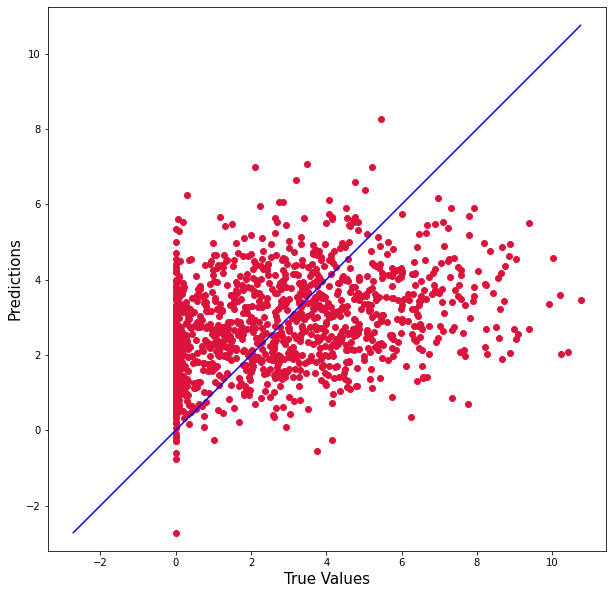

In [69]:
multireg_model_wrapper(comp_kmers_count_df_4)